In [1]:
import re
from nltk.tokenize.casual import TweetTokenizer
from gensim.models import KeyedVectors
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.callbacks import ModelCheckpoint
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.
/home/rdalex/venv3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rdalex/venv3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rdalex/venv3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rdalex/venv3/lib/python3.6/site-packages/tensorflow/python/fra

Load words embeddings (FastText trained over VK posts)

In [2]:
fasttext = KeyedVectors.load_word2vec_format('embeddings/fasttext_big_300d.vec')
fasttext.most_similar('котейка')

[('котейко', 0.7458697557449341),
 ('Котейка', 0.7427492141723633),
 ('котейки', 0.6791476011276245),
 ('котейкой', 0.6727944612503052),
 ('кошак', 0.6622782945632935),
 ('котэ', 0.6595468521118164),
 ('совушка', 0.658632755279541),
 ('киса', 0.642015278339386),
 ('котейку', 0.633861243724823),
 ('собакадругчеловека', 0.6230987310409546)]

In [3]:
fasttext.most_similar('cat')

[('cats', 0.8391395211219788),
 ('kitten', 0.8023779988288879),
 ('dog', 0.7982020378112793),
 ('kittens', 0.7829532623291016),
 ('pet', 0.7627919912338257),
 ('kitty', 0.7567681074142456),
 ('catsagram', 0.7563411593437195),
 ('catstagram', 0.75223708152771),
 ('petstagram', 0.7464101314544678),
 ('catsofinstagram', 0.7379685640335083)]

Load tweets (https://study.mokoron.com/)

In [4]:
pd.set_option('max_colwidth', -1)

negative = pd.read_csv('datasets/negative.csv', header=None, sep=';', usecols=[3])
negative['class'] = 0
positive = pd.read_csv('datasets/positive.csv', header=None, sep=';', usecols=[3])
positive['class'] = 1
df = pd.concat([negative, positive], ignore_index=True, copy=False)
df = df.sample(frac=1).reset_index(drop=True)
df.rename(columns={3: 'text'}, inplace=True)
df.head(n=10)

,text,class
0,@KrisVarvina ну да по приколу) думаешь найдется принц?),1
1,"В 5 классе будет учиться, на радость англичанке нашей))",1
2,@fantomrocker а я типа на расслабоне такая чувиха7)) тоже вот потею))),1
3,RT @anya_pervert: Сказал в 7 часов позвонить и отчитаться за выбор),1
4,"“@Summer_day_day: Однажды Чен признался, что он очень упрямый и возьмет то, что очень хочет, даже если это - девушка Криса.\nзачет”\nРисковый)",1
5,"Целых десять дней...черт, как же это долго. Приезжай по-скорее, я тебя жду, любимая:* крабушу моя:*… http://t.co/8hpklZNrYy",1
6,Он такой пидр ебанутый пиздеец! #сорризаматы(,0
7,"Опа, прилетело обновление до Android 4.4.2 на Nexus 4! Оперативно работают ребята :) http://t.co/Uy75zeP1ZU",1
8,в последнее время не читаю длинные посты\n\nтааак в падлу),1
9,чо происходит RT @nindo_O: @Badou_N http://t.co/AemUGmrG7Y,0


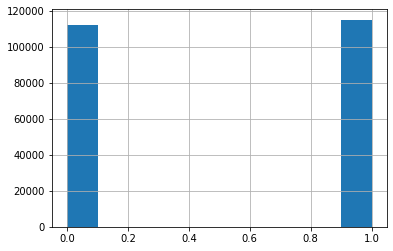

In [5]:
df['class'].hist()

In [6]:
df['class'].value_counts()

1    114911
0    111923
Name: class, dtype: int64

Clean text

In [7]:
def preprocess_text(text):
    # Lower text
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove @ mentions
    text = re.sub(r"@\S+", "", text)
    # Remove hashtags
    text = re.sub(r"#\S+", "", text)
    # Remove rt (retweets)
    text = re.sub("rt", "", text)
    # Remove unneeded symbols
    text = re.sub(r"[/~/`/@/#/$/%/&/-/_/+/,/.]", "", text)
    # Remove extra spaces
    text = re.sub(" +", ' ', text)
    
    return text

In [8]:
tweet_tokenizer = TweetTokenizer()
X = []
y = []

for _, row in df.iterrows():
    txt = preprocess_text(row['text'])
    tokenized_text = ''
    try:
        tokenized_text = tweet_tokenizer.tokenize(txt)
    except:
        continue
    replaced_by_num = [fasttext.vocab[word].index for word in tokenized_text if word in fasttext.vocab]
    X.append(replaced_by_num)
    y.append(row['class'])

The longest sentence length

In [9]:
max([len(x) for x in X])

47

Divide data into the train and test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, 
                                                    random_state=42)

Embedding layer params

In [11]:
fasttext.get_keras_embedding().get_config()

{'name': 'embedding_1',
 'trainable': False,
 'batch_input_shape': (None, None),
 'dtype': 'float32',
 'input_dim': 507470,
 'output_dim': 300,
 'embeddings_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': False,
 'input_length': None}

In [12]:
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

Training

In [14]:
maxlen = 50
batch_size = 128
epochs = 50

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()
model.add(fasttext.get_keras_embedding())
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

callbacks = [ModelCheckpoint(filepath='trained_models/fasttext_bilstm.h5', 
                             monitor='val_loss', 
                             save_best_only=True)
            ]
model.compile('adadelta', 'binary_crossentropy', metrics=[precision, recall, f1])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=0.15, 
                    callbacks=callbacks)

X_train shape: (170125, 50)
X_test shape: (56709, 50)
Train on 144606 samples, validate on 25519 samples
Epoch 1/50
144606/144606 [==============================] - 79s 547us/step - loss: 0.2752 - precision: 0.8609 - recall: 0.8777 - f1: 0.8648 - val_loss: 0.2291 - val_precision: 0.8950 - val_recall: 0.8703 - val_f1: 0.8817
Epoch 2/50
144606/144606 [==============================] - 78s 537us/step - loss: 0.2212 - precision: 0.8886 - recall: 0.8880 - f1: 0.8867 - val_loss: 0.2149 - val_precision: 0.8970 - val_recall: 0.8833 - val_f1: 0.8893
Epoch 3/50
144606/144606 [==============================] - 77s 535us/step - loss: 0.2098 - precision: 0.8943 - recall: 0.8928 - f1: 0.8922 - val_loss: 0.2095 - val_precision: 0.9036 - val_recall: 0.8815 - val_f1: 0.8916
Epoch 4/50
144606/144606 [==============================] - 77s 534us/step - loss: 0.2031 - precision: 0.8982 - recall: 0.8975 - f1: 0.8966 - val_loss: 0.2099 - val_precision: 0.9323 - val_recall: 0.8500 - val_f1: 0.8884
Epoch 5/50


144606/144606 [==============================] - 77s 534us/step - loss: 0.0594 - precision: 0.9768 - recall: 0.9741 - f1: 0.9752 - val_loss: 0.3949 - val_precision: 0.8976 - val_recall: 0.8997 - val_f1: 0.8981
Epoch 38/50
144606/144606 [==============================] - 77s 535us/step - loss: 0.0566 - precision: 0.9782 - recall: 0.9758 - f1: 0.9768 - val_loss: 0.4240 - val_precision: 0.8931 - val_recall: 0.9089 - val_f1: 0.9003
Epoch 39/50
144606/144606 [==============================] - 77s 534us/step - loss: 0.0523 - precision: 0.9801 - recall: 0.9782 - f1: 0.9790 - val_loss: 0.4468 - val_precision: 0.9048 - val_recall: 0.8949 - val_f1: 0.8992
Epoch 40/50
144606/144606 [==============================] - 77s 534us/step - loss: 0.0489 - precision: 0.9818 - recall: 0.9797 - f1: 0.9806 - val_loss: 0.4578 - val_precision: 0.9058 - val_recall: 0.8932 - val_f1: 0.8989
Epoch 41/50
144606/144606 [==============================] - 77s 535us/step - loss: 0.0460 - precision: 0.9822 - recall: 0.9

Some plots

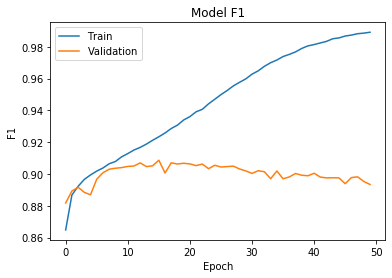

In [15]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

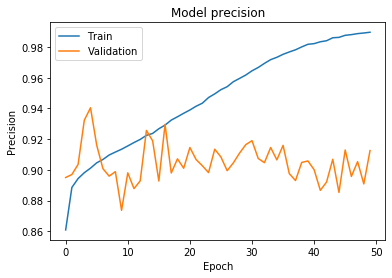

In [16]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

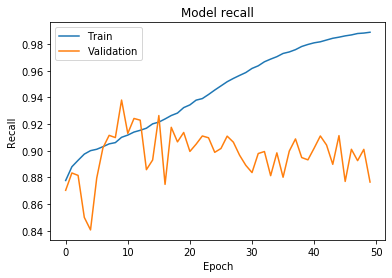

In [17]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

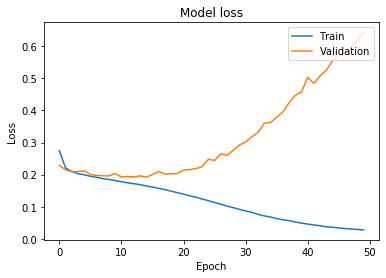

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Test scores

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test, model.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89     28011
           1       0.91      0.88      0.89     28698

    accuracy                           0.89     56709
   macro avg       0.89      0.89      0.89     56709
weighted avg       0.89      0.89      0.89     56709

